In [ ]:
import sys

prefix = ".."
sys.path.insert(0, prefix)

from common.config import create_object, load_config

%matplotlib widget

import torch
torch._dynamo.config.suppress_errors = True
torch._dynamo.disable()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import time
import glob
import itertools
import datetime
import copy
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import deepxde as dde
import matplotlib.cm as cm
import ruptures as rpt
import random

from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from copy import deepcopy

from omegaconf import DictConfig, OmegaConf, ListConfig

import utils
from omegaconf import DictConfig, OmegaConf
from models import *

class NewTimeInputModel():
  def __init__(self, dataset, ticlass, tiinfo, activation, td=None, seed=0, device=0, residual=0):
    self.dataset = dataset
    self.device = device
    self.td = td
    self.residual = residual
  
    if self.td is None:
      self.prefix = f"{self.dataset.name}{str(ticlass.__name__)}"
    else:
      self.prefix = self.td

    torch.manual_seed(seed)
    np.random.seed(seed)
    self.seed = seed
    self.timetaken = 0

    datacopy = self.dataset.data.copy()
    self.numtrain = int(datacopy.shape[0] * 0.8)
    
    self.T = self.dataset.data.shape[1]
    self.trainarr = datacopy[:self.numtrain]
    self.testarr = datacopy[self.numtrain:]

    self.ticlass = ticlass
    self.optparams = None

    self.datadim = len(self.dataset.data.shape) - 2
    if len(tiinfo) == 1:
      self.model = self.ticlass(tiinfo[0], activation).to(self.device)
    elif len(tiinfo) == 2:
      self.model = self.ticlass(tiinfo[0], tiinfo[1], activation).to(self.device)
    else:
      assert(False)

    #self.tidata = [ticlass, tiinfo]
    #self.datadata = [np.floor(np.sum(self.dataset.data) * 100), self.dataset.data.shape]

    self.metadata = {
      "model_class": ticlass.__name__,
      "tiinfo": tiinfo,
      "activation": activation.__name__ if hasattr(activation, '__name__') else str(activation),
      "dataset_name": dataset.name,
      "data_shape": list(dataset.data.shape),
      "data_checksum": float(np.sum(dataset.data)),
      "seed": seed,
    }

    self.epochs = []

  def get_ti_errors(self, testarr, ords=(2,), times=None, aggregate=True, tstart=0):
    assert(aggregate or len(ords) == 1)
    
    if isinstance(testarr, np.ndarray):
      testarr = torch.tensor(testarr, dtype=torch.float32)

    if times is None:
      times = torch.linspace(0, 1, self.T, dtype=testarr.dtype)[tstart+1:]
  
    out = self.forward(testarr[:, tstart], times)
    
    n = testarr.shape[0]
    orig = testarr[:, tstart+1:].cpu().detach().numpy()
    out = out.cpu().detach().numpy()

    if aggregate:
      orig = orig.reshape([n, -1])
      out = out.reshape([n, -1])
      testerrs = []
      for o in ords:
        testerrs.append(np.mean(np.linalg.norm(orig - out, axis=1, ord=o) / np.linalg.norm(orig, axis=1, ord=o)))

      return tuple(testerrs)
    
    else:
      o = ords[0]
      testerrs = []

      if len(times) == 1:
        t = times[0]
        origslice = orig[:, t-1].reshape([n, -1])
        outslice = out.reshape([n, -1])
        return np.linalg.norm(origslice - outslice, axis=1, ord=o) / np.linalg.norm(origslice, axis=1, ord=o)
      else:
        for t in range(orig.shape[1]):
          origslice = orig[:, t].reshape([n, -1])
          outslice = out[:, t].reshape([n, -1])
          testerrs.append(np.mean(np.linalg.norm(origslice - outslice, axis=1, ord=o) / np.linalg.norm(origslice, axis=1, ord=o)))

        return testerrs

  def forward(self, x, ts):
    if isinstance(self.model, FFNet):
      origshape = list(x.shape[-self.datadim:])

      x = x.reshape(list(x.shape[:-self.datadim]) + [-1])

      T = ts.shape[0]
      x_exp = x.unsqueeze(-2)
      t_exp = ts.reshape(*([1] * (x.dim() - 1)), -1, 1)

      x_brd = x_exp.expand(*x.shape[:-1], T, x.shape[-1])
      t_brd = t_exp.expand(*x.shape[:-1], T, 1)

      xts = torch.cat((x_brd, t_brd), dim=-1)         
  
      out = self.model(xts)


      output = out.reshape(list(out.shape)[:-1] + origshape)

      if self.residual == 2:
        return xts[..., :-1] + t_brd * output
      elif self.residual == 1:
        return xts[..., :-1] + output
      else:
        return output
        
    elif isinstance(self.model, DeepONet):
      B, S = x.shape
      device = x.device

      ts_tensor = torch.as_tensor(ts, device=device)
      spaces = torch.linspace(0, 1, S, device=device)

      s_grid, t_grid = torch.meshgrid(spaces, ts_tensor, indexing='ij')

      inputs = torch.stack((s_grid, t_grid), dim=-1)
      
      out = self.model(x, inputs)
      return out
    
    else:
      assert(False)

  def load_model(self, filename_prefix, verbose=False, min_epochs=0):
    search_path = f"savedmodels/timeinput/{filename_prefix}*.pickle"
    matching_files = glob.glob(search_path)

    print("Searching for model files matching prefix:", filename_prefix)
    if not hasattr(self, "metadata"):
        raise ValueError("Missing self.metadata. Cannot match models without metadata. Ensure model has been initialized with same config.")

    for addr in matching_files:
      try:
          with open(addr, "rb") as handle:
              dic = pickle.load(handle)
      except Exception as e:
          if verbose:
              print(f"Skipping {addr} due to read error: {e}")
          continue

      meta = dic.get("metadata", {})
      is_match = all(
          meta.get(k) == self.metadata.get(k)
          for k in meta.keys()
      )

      # Check if model meets the minimum epoch requirement
      model_epochs = dic["epochs"]
      if model_epochs is None:
          if verbose:
              print(f"Skipping {addr} due to missing epoch metadata.")
          continue
      elif isinstance(model_epochs, list):  # handle legacy or list format
          if sum(model_epochs) < min_epochs:
              if verbose:
                  print(f"Skipping {addr} due to insufficient epochs ({sum(model_epochs)} < {min_epochs})")
              continue
      elif model_epochs < min_epochs:
          if verbose:
              print(f"Skipping {addr} due to insufficient epochs ({model_epochs} < {min_epochs})")
          continue

      if is_match:
          print("Model match found. Loading from:", addr)
          self.model.load_state_dict(dic["model"])
          self.epochs = model_epochs
          self.timetaken = dic["timetaken"]
          if "opt" in dic:     
            self.optparams = dic["opt"]

          return True
      elif verbose:
          print("Metadata mismatch in file:", addr)
          for k in self.metadata:
              print(f"{k}: saved={meta.get(k)} vs current={self.metadata.get(k)}")

    print("Load failed. No matching models found.")
    print("Searched:", matching_files)
    return False

  def train_model(self, epochs, save=True, optim=torch.optim.AdamW, lr=1e-4, printinterval=10, batch=32, ridge=0, loss=None, best=True, verbose=False, numts=1):
    def train_epoch(dataloader, writer=None, optimizer=None, scheduler=None, ep=0, printinterval=10, loss=None, testarr=None):
      losses = []
      testerrors1 = []
      testerrors2 = []
      testerrorsinf = []

      def closure(batch):
        optimizer.zero_grad()
        
        #res = 0
        alltimes = torch.linspace(0, 1, self.T, dtype=batch.dtype)
        #for t in range(self.T):
        
        ts = random.sample(range(self.T), numts)
        res = 0
        for t in ts:
          out = self.forward(batch[:, t], alltimes[t+1:])
          res += loss(batch[:, t+1:], out)
          
        res /= len(ts)
        res.backward()
        
        if writer is not None and self.trainstep % 5 == 0:
          writer.add_scalar("main/loss", res, global_step=self.trainstep)

        return res

      for batch in dataloader:
        self.trainstep += 1
        error = optimizer.step(lambda: closure(batch))
        losses.append(float(error.cpu().detach()))

      if scheduler is not None:
        scheduler.step(np.mean(losses))

      # print test
      if printinterval > 0 and (ep % printinterval == 0):
        testerr1, testerr2, testerrinf = self.get_ti_errors(testarr, ords=(1, 2, np.inf))
        if scheduler is not None:
          print(f"{ep+1}: Train Loss {error:.3e}, LR {scheduler.get_last_lr()[-1]:.3e}, Relative TI Error (1, 2, inf): {testerr1:3f}, {testerr2:3f}, {testerrinf:3f}")
        else:
          print(f"{ep+1}: Train Loss {error:.3e}, Relative TI Error (1, 2, inf): {testerr1:3f}, {testerr2:3f}, {testerrinf:3f}")

        if writer is not None:
            writer.add_scalar("misc/relativeL1error", testerr1, global_step=ep)
            writer.add_scalar("main/relativeL2error", testerr2, global_step=ep)
            writer.add_scalar("misc/relativeLInferror", testerrinf, global_step=ep)

      return losses, testerrors1, testerrors2, testerrorsinf
  
    loss = nn.MSELoss() if loss is None else loss()

    losses, testerrors1, testerrors2, testerrorsinf = [], [], [], []
    self.trainstep = 0

    train = torch.tensor(self.trainarr, dtype=torch.float32).to(self.device)
    test = self.testarr  

    opt = optim(self.model.parameters(), lr=lr, weight_decay=ridge)
    scheduler = lr_scheduler.ReduceLROnPlateau(opt, patience=20, factor=0.3)
    dataloader = DataLoader(train, shuffle=False, batch_size=batch)

    if self.optparams is not None:
      opt.load_state_dict(self.optparams)

    writer = None
    if self.td is not None:
      name = f"./tensorboard/{datetime.datetime.now().strftime('%d-%B-%Y')}/{self.td}/{datetime.datetime.now().strftime('%H.%M.%S')}/"
      writer = torch.utils.tensorboard.SummaryWriter(name)
      print("Tensorboard writer location is " + name)

    print("Number of NN trainable parameters", utils.num_params(self.model))
    print(f"Starting training TI model {self.metadata['model_class']} at {time.asctime()}...")
    print("train", train.shape, "test", test.shape)
      
    start = time.time()
    bestdict = { "loss": float(np.inf), "ep": 0 }
    for ep in range(epochs):
      lossesN, testerrors1N, testerrors2N, testerrorsinfN = train_epoch(dataloader, optimizer=opt, scheduler=scheduler, writer=writer, ep=ep, printinterval=printinterval, loss=loss, testarr=test)
      losses += lossesN; testerrors1 += testerrors1N; testerrors2 += testerrors2N; testerrorsinf += testerrorsinfN

      if best and ep > epochs // 2:
        avgloss = np.mean(lossesN)
        if avgloss < bestdict["loss"]:
          bestdict["model"] = self.model.state_dict()
          bestdict["opt"] = opt.state_dict()
          bestdict["loss"] = avgloss
          bestdict["ep"] = ep
        elif verbose:
          print(f"Loss not improved at epoch {ep} (Ratio: {avgloss/bestdict['loss']:.2f}) from {bestdict['ep']} (Loss: {bestdict['loss']:.2e})")
      
    end = time.time()
    self.timetaken += end - start
    print(f"Finished training TI model {self.metadata['model_class']} at {time.asctime()}...")

    if best:
      self.model.load_state_dict(bestdict["model"])
      opt.load_state_dict(bestdict["opt"])

    self.optparams = opt.state_dict()
    self.epochs.append(epochs)

    if save:
      now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
      readable_shape = "x".join(map(str, self.metadata["tiinfo"]))

      # Compute total training epochs
      total_epochs = sum(self.epochs) if isinstance(self.epochs, list) else self.epochs

      filename = (
          f"{self.dataset.name}_"
          f"{self.ticlass.__name__}_"
          f"{self.metadata['activation']}_"
          f"{readable_shape}_"
          f"{self.seed}_"
          f"{total_epochs}ep_"
          f"{now}.pickle"
      )

      dire = "savedmodels/timeinput"
      addr = os.path.join(dire, filename)

      if not os.path.exists(dire):
          os.makedirs(dire)

      with open(addr, "wb") as handle:
          pickle.dump({
              "model": self.model.state_dict(),
              "metadata": self.metadata,
              "opt": self.optparams,
              "epochs": self.epochs,
              "timetaken": self.timetaken
          }, handle, protocol=pickle.HIGHEST_PROTOCOL)

      print("Model saved at", addr)

    return { "losses": losses, "testerrors1": testerrors1, "testerrors2": testerrors2, "testerrorsinf": testerrorsinf }

class NewTimeInputHelper():
  def __init__(self, config):
    self.update_config(config)

  def update_config(self, config):
    self.config = deepcopy(config)

  def create_timeinput(self, dataset, config=None, **args):
    if config is None:
      config = self.config

    assert(len(dataset.data.shape) < 5)
    if len(dataset.data.shape) == 3:
      din = dataset.data.shape[2]
    else:
      din = dataset.data.shape[2] * dataset.data.shape[3]

    td = args.get("td", None)
    seed = args.get("seed", 0)
    device = args.get("device", 0)
    k = args.get("k", None)

    residual = args.get("residual", 0)

    ticlass = args.get("ticlass", config.ticlass)

    assert(ticlass == "FFNet")
    ticlass = FFNet
    ffseq = deepcopy(args.get("ffseq", config.ffseq))

    ffseq[0] = din + 1
    ffseq[-1] = din

    tiinfo = (ffseq,)

    activation = get_activation(args.get("activation", config.activation))

    return NewTimeInputModel(dataset, ticlass, tiinfo, activation, td=td, seed=seed, device=device, residual=residual)

  @staticmethod
  def get_operrs(ti, times=None, testonly=True):
    if isinstance(ti, NewTimeInputModel):
      if testonly:
        data = ti.testarr
      else:
        data = np.concatenate((ti.trainarr, ti.testarr), axis=0)

      errors = ti.get_ti_errors(data, times=times, aggregate=False)
    elif isinstance(ti, WeldNet):
      errors = WeldHelper.get_operrs(ti, testonly=testonly)
    elif isinstance(ti, HighDimProp):
      errors = HighDimPropHelper.get_operrs(ti, testonly=testonly)
    elif isinstance(ti, ELDNet):
      errors = ELDHelper.get_operrs(ti, testonly=testonly)
      
    return errors
  
  @staticmethod
  def plot_op_predicts(ti: NewTimeInputModel, testonly=True, xs=None, cmap="viridis"):
    if testonly:
      data = ti.trainarr
    else:
      data = np.concatenate((ti.trainarr, ti.testarr), axis=0)

    if xs is None:
        xs = np.linspace(0, 1, data.shape[2])

    data = torch.tensor(np.float32(data)).to(ti.device)

    times = torch.arange(1, ti.T)
    tt = times.to(ti.device) / ti.T
    predicts = ti.forward(data[:, 0], tt)
    
    predicts = predicts.cpu().detach()
    data = data.cpu().detach()

    errors = []
    n = predicts.shape[0]
    for s in times:
      currpredict = predicts[:, s-1].reshape((n, -1))
      currreference = data[:, s].reshape((n, -1))
      errors.append(np.mean(np.linalg.norm(currpredict - currreference, axis=1) / np.linalg.norm(currreference, axis=1)))
        
    print(f"Average Relative L2 Error over all times: {np.mean(errors):.4f}")

    if len(data.shape) == 3:
      fig, ax = plt.subplots(figsize=(4, 3))
    elif len(data.shape) == 4:
      fig, axes = plt.subplots(1, 4, figsize=(12, 3))
      fig.subplots_adjust(right=0.90)
      sub_ax = plt.axes([0.91, 0.15, 0.02, 0.65])

    @widgets.interact(i=(0, n-1), s=(1, ti.T-1))
    def plot_interact(i=0, s=1):
      print(f"Avg Relative L2 Error for t0 to t{s}: {errors[s-1]:.4f}")

      if len(data.shape) == 3:
        ax.clear()
        ax.set_title(f"RelL2 {np.linalg.norm(predicts[i, s-1] - data[i, s]) / np.linalg.norm(data[i, s])}")
        ax.plot(xs, data[i, 0], label="Input", linewidth=1)
        ax.plot(xs, predicts[i, s-1], label="Predicted", linewidth=1)
        ax.plot(xs, data[i, s], label="Exact", linewidth=1)
        ax.legend()
      elif len(data.shape) == 4:
        for axx in axes:
          axx.clear()

        axes[0].imshow(data[i, 0], cmap=cmap)
        axes[0].set_title("Initial")
        axes[1].imshow(data[i, s], cmap=cmap)
        axes[1].set_title("Exact")
        axes[2].imshow(predicts[i, s-1], cmap=cmap)
        axes[2].set_title("Predicted")

        cb = axes[3].imshow(np.abs(predicts[i, s-1] - data[i, s]), cmap=cmap)
        axes[3].set_title("|Difference|")
        fig.colorbar(cb, cax=sub_ax)

  @staticmethod
  def compare_operrs(models, labels=None):
    fig, ax = plt.subplots()

    if labels is None:
      labels = range(len(models))

    for lbl, x in zip(labels, models):
      operrs = TimeInputHelper.get_operrs(x, testonly=True)
      ax.plot(np.log10(operrs), label=lbl)

    ax.legend()
    #ax.set_title("Operator Error for Various #Windows")
    ax.set_ylabel("$log_{10}$(Operator Error)")
    ax.set_xlabel("Time")

    fig.tight_layout()
    return fig

  @staticmethod
  def plot_errorparams(ti, param=-1):
    if param == -1:
        # Auto-detect one varying parameter
        param = 0
        P = ti.dataset.params.shape[1]
        for p in range(P):
            if np.abs(ti.dataset.params[0, p] - ti.dataset.params[1, p]) > 0:
                param = p
                break

    l2error = np.asarray(TimeInputHelper.get_operrs(ti, times=[ti.T - 1]))
    params = ti.dataset.params

    print(params.shape, l2error.shape)

    if isinstance(param, (list, tuple, np.ndarray)) and len(param) == 2:
        # 3D scatter plot for 2 varying parameters
        x = params[:, param[0]]
        y = params[:, param[1]]
        z = l2error

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=10)

        ax.set_xlabel(f"Param {param[0]}")
        ax.set_ylabel(f"Param {param[1]}")
        ax.set_zlabel("Operator Error")
        fig.colorbar(sc, ax=ax, label="Operator Error")

    else:
        # Fallback to 2D scatter if param is 1D
        fig, ax = plt.subplots()
        ax.scatter(params[:, param], l2error, s=2)
        ax.set_xlabel(f"Parameter {param}")
        ax.set_ylabel("Operator Error")

    fig.tight_layout()

  @staticmethod
  def compare_errorparams(tis, labels=None, param=-1):
    if param == -1:
      param = 0
      P = tis[0].dataset.params.shape[1]

      for p in range(P):
        if np.abs(tis[0].dataset.params[0, p] - tis[0].dataset.params[1, p]) > 0:
          param = p
          break
      
    if labels is None:
      labels = [utils.num_params(x.model) for x in tis]

    fig, ax = plt.subplots()
    for lbl, ti in zip(labels, tis):
      l2error = np.asarray(TimeInputHelper.get_operrs(ti, times=[ti.T-1], testonly=False))
      print(l2error.shape, ti.dataset.params[:, param].shape)
      ax.scatter(ti.dataset.params[:, param], l2error, label=lbl, s=2)
  
    ax.set_title(f"Error vs. Parameter {param}")
    ax.set_xlabel("Parameter Value")
    ax.set_ylabel("Operator Error")
    ax.legend()

    fig.tight_layout()
    return fig


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
# load
dconfig = load_config(f"../configs/data/transport/hats2dscale.yaml")
dconfig.datasize.spacedim = 1
dset = create_object(dconfig)

In [4]:
config = load_config("../configs/experiments/ffnetnormal.yaml")
experiment = NewTimeInputHelper(config)

In [5]:
test = experiment.create_timeinput(dset)

In [7]:
test.train_model(200, save=False, batch=32, lr=1e-3, numts=10)

Number of NN trainable parameters 2417424
Starting training TI model FFNet at Tue Sep  9 20:44:24 2025...
train torch.Size([400, 301, 1024]) test (100, 301, 1024)
1: Train Loss 5.187e-04, LR 1.000e-03, Relative TI Error (1, 2, inf): 2.969677, 1.220578, 1.080336
11: Train Loss 1.175e-04, LR 1.000e-03, Relative TI Error (1, 2, inf): 1.403337, 0.588381, 0.732783
21: Train Loss 3.932e-05, LR 1.000e-03, Relative TI Error (1, 2, inf): 0.894016, 0.357749, 0.636070
31: Train Loss 2.585e-05, LR 1.000e-03, Relative TI Error (1, 2, inf): 0.747363, 0.311226, 0.486692
41: Train Loss 2.190e-05, LR 1.000e-03, Relative TI Error (1, 2, inf): 0.586202, 0.218049, 0.471925
51: Train Loss 3.058e-05, LR 1.000e-03, Relative TI Error (1, 2, inf): 0.588217, 0.205554, 0.382812
61: Train Loss 1.285e-04, LR 1.000e-03, Relative TI Error (1, 2, inf): 1.050734, 0.518655, 0.695509


KeyboardInterrupt: 

In [30]:
vals = []
for t in range(0, 300, 10):
  vals.append(test.get_ti_errors(test.testarr, tstart=t)[0])
  print(t, end=" ")

print()
plt.plot(vals)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 


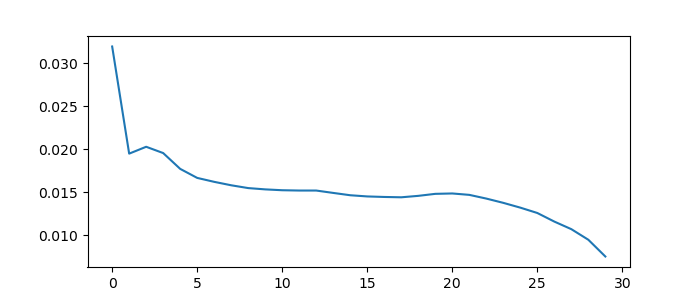

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

In [31]:
fig, ax = plt.subplots()

ax.plot(vals)